# Extract Stats from Basketball-Reference.com

2017-11

Scrap data from basketball-reference.com, using pd.read_html, BeaultifulSoup, Multiprocessing, & Other python modules.

## Imports, Constants, Utilities

### Imports

In [207]:
%%time

import os
import sys
import datetime
import re

import json
import pickle
import urllib
import pandas as pd
import google
import random
import time
import multiprocessing
import gspread
import unidecode
import tqdm


from collections import OrderedDict
from gspread import WorksheetNotFound
from bs4 import BeautifulSoup
from oauth2client.service_account import ServiceAccountCredentials

DATETIME_STRING_FORMAT = '%Y-%m-%d %H:%M:%S'

CPU times: user 4.42 ms, sys: 3.99 ms, total: 8.41 ms
Wall time: 7.74 ms


In [2]:
%%time

def merge_list_of_list(nested_list):
    flattened_list = [item for lst in nested_list for item in lst]
    return flattened_list

test_list = [['a'], ['b']]
merge_list_of_list(test_list)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 5.96 µs


In [3]:
%%time

# Utility function to merge retrived data tables into 1 dictionary.
def merge_list_of_dict(list_of_dict):
    merged_dict = {}
    for dictionary in list_of_dict:
        merged_dict.update(dictionary)
    # Sort by dictionary key
    ordered_dict = OrderedDict(sorted(merged_dict.items(), key=lambda t: t[0]))
    return ordered_dict

test_list = [
    {'michael jordan': {'tables': {}, 'missing_tables': 'none', 'url': 'diety'}},
    {'kobe bryant': {'tables': {}, 'missing_tables': 'none', 'url': 'godly'}},
]

dic = merge_list_of_dict(test_list)
print(dic)

OrderedDict([('kobe bryant', {'tables': {}, 'missing_tables': 'none', 'url': 'godly'}), ('michael jordan', {'tables': {}, 'missing_tables': 'none', 'url': 'diety'})])
CPU times: user 190 µs, sys: 130 µs, total: 320 µs
Wall time: 270 µs


In [4]:
%%time

def sanitize_string(raw_string):
    sanitized_string = unidecode.unidecode(raw_string)
    sanitized_string = sanitized_string.strip().lower()
    sanitized_string = sanitized_string.replace("'", "")
    sanitized_string = sanitized_string.replace('"', '') 
    sanitized_string = sanitized_string.replace('.', '')
    if "," in sanitized_string:
        lst = sanitized_string.split(",")
        lst.reverse()
        lst = [token.strip() for token in lst]
        sanitized_string = " ".join(lst)
    return sanitized_string

print(sanitize_string("Shaquille O'neal"))
print(sanitize_string("Bryant, Kobe"))
print(sanitize_string(" CarTer, Vince .."))

shaquille oneal
kobe bryant
vince carter
CPU times: user 119 µs, sys: 50 µs, total: 169 µs
Wall time: 173 µs


In [5]:
%%time

def sanitize_list(raw_list):
            
    sanitized_list = [sanitize_string(raw_string) for raw_string in raw_list]
    return sanitized_list

test_list = ["Shaquille O'neal", "J. J. Reddick", "VinCe Carter ", "Bryant, Kobe"]

print(sanitize_list(test_list))

['shaquille oneal', 'j j reddick', 'vince carter', 'kobe bryant']
CPU times: user 263 µs, sys: 230 µs, total: 493 µs
Wall time: 295 µs


In [6]:
%%time

def dedupe_list(lst):
    return list(set(lst))

print(dedupe_list(['a', 'a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'b', ]))

['b', 'a']
CPU times: user 276 µs, sys: 316 µs, total: 592 µs
Wall time: 575 µs


### Load Spreadsheets

In [7]:
def load_list_from_worksheet(spreadsheet_name, worksheet_name):
  
    scope = ['https://spreadsheets.google.com/feeds']
    credentials = ServiceAccountCredentials.from_json_keyfile_name('Data-35df9a696bc1.json', scope)
    gc = gspread.authorize(credentials)

    spreadsheet = gc.open(spreadsheet_name)
    worksheet = spreadsheet.worksheet(worksheet_name)

    rows = worksheet.get_all_values()
    
    first_row = rows[0]
    first_cell = first_row[0]
    
    try:
        timestamp = datetime.datetime.strptime(first_cell, DATETIME_STRING_FORMAT)
        rows.remove(first_row)
    except ValueError:
        timestamp = None

    print(
        'LOADED > {num_rows} rows from '
        'spreadsheet: "{spreadsheet_name}" | '
        'worksheet: "{worksheet_name}" | '
        'timestamp: {timestamp}'.format(
            num_rows=len(rows), spreadsheet_name=spreadsheet_name, 
            worksheet_name=worksheet_name, timestamp=timestamp), '\n')

    df = merge_list_of_list(rows)
    
    return df

worksheet = load_list_from_worksheet('test_spreadsheet', 'test')
print(worksheet[:10])

LOADED > 100 rows from spreadsheet: "test_spreadsheet" | worksheet: "test" | timestamp: 2017-11-21 14:38:03 

['michale', 'kobe', '0', '1', '2', '3', '4', '5', '6', '7']


In [8]:
%%time

def save_list_to_worksheet(lst, spreadsheet_name, worksheet_name, add_timestamp=True, overwrite=False):
    scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
    credentials = ServiceAccountCredentials.from_json_keyfile_name('Data-35df9a696bc1.json', scope)
    gc = gspread.authorize(credentials)
    
    spreadsheet = gc.open(spreadsheet_name)
    
    if type(lst) is not list:
        print('ERROR: input item is not a list!')
        return False
    
    # Remove rows with None value
    original_length = len(lst)
    lst = [item for item in lst if item is not None]
    new_length = len(lst)
    
    try:
        worksheet = spreadsheet.worksheet(worksheet_name)
        if overwrite:
            new_worksheet_name = worksheet_name + "_new"
            new_worksheet = spreadsheet.add_worksheet(new_worksheet_name, len(lst), 1)
            spreadsheet.del_worksheet(worksheet)
            new_worksheet.update_title(worksheet_name)
        else:
            print('Worksheet "{worksheet_name}" already exist! Please set overwrite=True to overwrite.')
            return False
    except WorksheetNotFound: 
        new_worksheet = spreadsheet.add_worksheet(worksheet_name, len(lst), 1)
    
    range_notation = 'A1:A{last_row_index}'.format(last_row_index=len(lst))
    
    cells_to_update = new_worksheet.range(range_notation)

    print('Remove {num_row} rows with "None" as their value.'.format(
        num_row=(original_length - new_length)))
    
    for cell, item in zip(cells_to_update, lst):
        cell.value = item
    
    new_worksheet.update_cells(cells_to_update)
    
    #Add a timestamp in the 1st cell
    if add_timestamp:
        timestamp = datetime.datetime.now()
        new_worksheet.insert_row(
            [timestamp], 1)
    
    print(
    'SAVED > {num_rows} rows to '
    'spreadsheet: "{spreadsheet_name}" | '
    'worksheet: "{worksheet_name}" | '
    'timestamp: {timestamp}'.format(
        num_rows=len(lst), spreadsheet_name=spreadsheet_name, 
        worksheet_name=worksheet_name, timestamp=timestamp), '\n')
    
    return True

test_lst = ['michale', 'kobe'] + [i for i in range(98)]
print(len(test_lst))
save_list_to_worksheet(test_lst, 'test_spreadsheet', 'test', add_timestamp=True, overwrite=True)

100
Remove 0 rows with "None" as their value.
SAVED > 100 rows to spreadsheet: "test_spreadsheet" | worksheet: "test" | timestamp: 2017-11-22 08:17:13.229936 

CPU times: user 98.9 ms, sys: 15.6 ms, total: 114 ms
Wall time: 7.5 s


### Save & Load Pickle

In [9]:
%%time

test = {
    'words': """
        Lorem ipsum dolor sit amet, consectetur adipiscing 
        elit. Mauris adipiscing adipiscing placerat. 
        Vestibulum augue augue, 
        pellentesque quis sollicitudin id, adipiscing.
        """,
    'list': list(range(10000)),
    'dict': dict((str(i),'a') for i in range(10000)),
    'int': 100,
    'float': 100.123456
}

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

def get_file_size(filename):
    statinfo = os.stat(filename)
    return sizeof_fmt(statinfo.st_size)

def save_pickle(item, filename):
    with open(filename, 'wb') as file:
        pickle.dump(item, file)
    print(
        '\n'
        'SAVED  > ',
        filename, ' | ', 
        get_file_size(filename), ' | ',
        'length: ', len(item),
        '\n')
    return True;

def load_pickle(filename):
    with open(filename, 'rb') as file:
        obj = pickle.load(file)
        print(
        '\n'
        'LOADED > ',
        filename, ' | ', 
        get_file_size(filename), ' | ',
        'length: ', len(obj),
        '\n')
        return obj

save_pickle(test, 'test.pickle')

len(load_pickle('test.pickle'))


SAVED  >  test.pickle  |  183.8 KiB  |  length:  5 


LOADED >  test.pickle  |  183.8 KiB  |  length:  5 

CPU times: user 11.6 ms, sys: 3.9 ms, total: 15.5 ms
Wall time: 16 ms


### Define & Load Constants

In [410]:
%%time

# Tables to retrieve for each player, by table html ids
TABLE_IDS = [
  'per_game',
  'totals',
  'per_minute', # per 36 minutes
  'per_poss', # per 100 possessions
  'advanced', # advanced
    
  'playoffs_per_game',
  'playoffs_totals',
  'playoffs_per_minute', # playoffs per 36 minutes
  'playoffs_per_poss', # playoffs per 100 possessions
  'playoffs_advanced', 
    
  'all_star',
  'all_college_stats',
  'all_salaries',
]

print('Current TABLE_IDS length: ', len(TABLE_IDS))

# Load player names
hof_names = sanitize_list(
    load_list_from_worksheet('nba_player_names', 'hof_names'))
retired_all_stars_names = sanitize_list(
    load_list_from_worksheet('nba_player_names', 'retired_all_stars_names'))
retired_all_nbas_names = sanitize_list(
    load_list_from_worksheet('nba_player_names', 'retired_all_nbas_names'))
players_2015_names = sanitize_list(
    load_list_from_worksheet('nba_player_names', 'players_2015_names'))

# Load URLs
hof_urls = load_list_from_worksheet('nba_player_urls', 'hof_urls')
retired_all_stars_urls = load_list_from_worksheet('nba_player_urls', 'retired_all_stars_urls')
retired_all_nbas_urls = load_list_from_worksheet('nba_player_urls', 'retired_all_nbas_urls')
players_2015_urls = load_list_from_worksheet('nba_player_urls', 'players_2015_urls')

Current TABLE_IDS length:  13
LOADED > 181 rows from spreadsheet: "nba_player_names" | worksheet: "hof_names" | timestamp: None 

LOADED > 352 rows from spreadsheet: "nba_player_names" | worksheet: "retired_all_stars_names" | timestamp: None 

LOADED > 191 rows from spreadsheet: "nba_player_names" | worksheet: "retired_all_nbas_names" | timestamp: None 

LOADED > 476 rows from spreadsheet: "nba_player_names" | worksheet: "players_2015_names" | timestamp: None 

LOADED > 131 rows from spreadsheet: "nba_player_urls" | worksheet: "hof_urls" | timestamp: 2017-11-21 13:21:32 

LOADED > 352 rows from spreadsheet: "nba_player_urls" | worksheet: "retired_all_stars_urls" | timestamp: 2017-11-21 13:21:41 

LOADED > 190 rows from spreadsheet: "nba_player_urls" | worksheet: "retired_all_nbas_urls" | timestamp: 2017-11-21 13:21:36 

LOADED > 476 rows from spreadsheet: "nba_player_urls" | worksheet: "players_2015_urls" | timestamp: 2017-11-21 13:21:46 

CPU times: user 651 ms, sys: 177 ms, total: 82

## Get Players

### Get players from a single URL

In [156]:
def get_players(url):
    
    href_pattern = re.compile('^\/players\/.\/[a-z0-9]*.html$')
    href_prefix = 'https://www.basketball-reference.com'
    
    page = urllib.request.urlopen(url)
    html = page.read()

    # Get the player name
    soup = BeautifulSoup(html, 'html.parser')
    
    els = soup.find_all('a', href=href_pattern)
    
    players = {}
    
    for el in els:
        if el.parent.name == 'td':
            player_name = sanitize_string(el.text)
            player_url = ''.join([href_prefix, el['href']])
            players[player_name] = player_url
    
    print('Scrapped {url} | Players Found: {len}'.format(url=url, len=len(players)))
    
    return players

players = get_players('https://www.basketball-reference.com/leagues/NBA_1967_totals.html')

Scrapped https://www.basketball-reference.com/leagues/NBA_1967_totals.html | Players Found: 123


### Get players from a list of URLs, Multiprocessing

In [157]:
%%time

def get_players_from_urls(urls, num_processes):
    p = multiprocessing.Pool(processes=num_processes)
    outputs = p.map(get_players, urls)
    p.close()
    final_output = merge_list_of_dict(outputs)
    print(
        'Scrapped {num_url} urls, found {num_player} players.'.format(
            num_url=len(urls), num_player=len(final_output)), '\n')
    return final_output

test_urls = [
    'https://www.basketball-reference.com/leagues/NBA_2015_totals.html',
    'https://www.basketball-reference.com/leagues/NBA_2010_totals.html'
]

players = get_players_from_urls(test_urls, 2)

Scrapped https://www.basketball-reference.com/leagues/NBA_2010_totals.html | Players Found: 442
Scrapped https://www.basketball-reference.com/leagues/NBA_2015_totals.html | Players Found: 492
Scrapped 2 urls, found 716 players. 

CPU times: user 8.46 ms, sys: 15.7 ms, total: 24.1 ms
Wall time: 3.51 s


## GET URL (DEPRECATED, replaced by "Get Players")

### Get URL for a player name

In [ ]:
# %%time

# #TODO(jameshu): Add logic to verify the url returned  in fact matches the player name
# # Currently, even gibberish player_name e.g. "James Hu" would have results returned.

# def get_url_title(url):
#     page = urllib.request.urlopen(url)
#     soup = BeautifulSoup(page, "html.parser")
#     return soup.title.text

# def get_url(player_name):       
#     query = (
#         'site:www.basketball-reference.com/players/*/*.html '
#         '{player_name} Overview').format(player_name=player_name)
#     print('query: ', query)

#     results = google.search(query=query, start=0, stop=1)
#     urls = list(results)        
    
#     time.sleep(random.randint(5, 10))
    
#     if urls:
#         return {player_name: urls[0]}
#     else:
#         print('url found: None')
#         return {player_name: None}
        
# # print(get_url('Michael Jordan'))

### Get URLs for a list of player names, MULTIPROCESSING

In [ ]:
# %%time

# def get_urls(player_names, num_processes):
#     p = multiprocessing.Pool(processes=num_processes)
#     outputs = p.map(get_url, player_names)
#     p.close()
#     return merge_list_of_dict(outputs)

# # print(get_urls(test_names[0:2], 2))

## Get stats tables

### Get stats table for an url

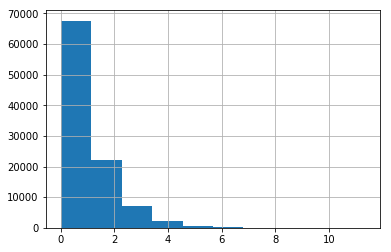

In [253]:
%matplotlib inline

import numpy as np

# mu, sigma = 0, 1
# s = np.random.normal(mu, sigma, 1000)
# pd.Series(s).hist()

mu, sigma = 0, 1
s = np.random.exponential(1, 100000)
pd.Series(s).hist()


In [370]:
%%time

def get_stats_table(url):
        
    output = {}
    
    page = urllib.request.urlopen(url)
    urlHtml = page.read().decode()
    
    # Uncomment the tables
    uncommentedUrlHtml = urlHtml.replace('-->', '')
    uncommentedUrlHtml = uncommentedUrlHtml.replace('<!--', '')

    soup = BeautifulSoup(uncommentedUrlHtml, 'lxml')
    
    player_name = sanitize_string(soup.find("h1").text)
    output.setdefault(player_name, {}).setdefault('url', url);

    tags = soup.find_all('table')
    
    found_table_ids = [tag.get('id') for tag in tags if tag.get('id') is not None]
    missing_table_ids = set(TABLE_IDS) - set(found_table_ids)
    
    output[player_name].setdefault('missing_tables', list(missing_table_ids));

    tables = pd.read_html(uncommentedUrlHtml, header=0, index_col=0, attrs={'id': TABLE_IDS})
    for dataframe in tables:
        dataframe.drop([col_name for col_name in dataframe.columns if 'Unnamed' in col_name], axis=1, inplace=True)
    output[player_name].setdefault('tables', tables);
    
    randomized_sleep_time = 1 + np.random.exponential(1, 1)[0]
    
    processing_info = (
        '{player_name} | Found: {num_table} | '
        'slept: {randomized_sleep_time}'.format(
            player_name=player_name, 
            num_table=len(output[player_name]['tables']), 
            missing_tables=missing_table_ids,
            randomized_sleep_time=randomized_sleep_time))
    
    print(processing_info)
    sys.stdout.flush()
    
    time.sleep(randomized_sleep_time)
    
    return output

table = get_stats_table('https://www.basketball-reference.com/players/b/bellawa01.html')
print(table['walt bellamy']['missing_tables'])

walt bellamy | Found: 11 | slept: 1.4895679170201044
['all_salaries', 'playoffs_per_poss']
CPU times: user 1.7 s, sys: 60 ms, total: 1.76 s
Wall time: 3.83 s


In [449]:
%%time

def get_stats_table(url):
        
    output = {}
    
    page = urllib.request.urlopen(url)
    urlHtml = page.read().decode()
    
    # Uncomment the tables
    uncommentedUrlHtml = urlHtml.replace('-->', '')
    uncommentedUrlHtml = uncommentedUrlHtml.replace('<!--', '')

    soup = BeautifulSoup(uncommentedUrlHtml, 'lxml')
    
    player_name = sanitize_string(soup.find("h1").text)
    output.setdefault(player_name, {}).setdefault('url', url);

    tags = soup.find_all('table')
    
    tables = {}
    missing_table_ids = list(TABLE_IDS) # MAKE A COPY
    
    for tag in tags:
        table_id = tag.get('id')
        if table_id in TABLE_IDS:
            table = pd.read_html(str(tag), header=0, index_col=0)[0]
            tables[table_id] = table
            missing_table_ids.remove(table_id)

    for dataframe in tables.values():
        dataframe.drop([col_name for col_name in dataframe.columns if 'Unnamed' in col_name], axis=1, inplace=True)
       
    output[player_name].setdefault('tables', tables);
    output[player_name].setdefault('missing_tables', missing_table_ids);
    
    randomized_sleep_time = 2 + np.random.exponential(1, 1)[0]
    time.sleep(randomized_sleep_time)
    
    processing_info = (
        '{player_name} | Found: {num_table} | '
        'slept: {randomized_sleep_time}'.format(
            player_name=player_name, 
            num_table=len(output[player_name]['tables']), 
            missing_tables=missing_table_ids,
            randomized_sleep_time=randomized_sleep_time))
    
    print(processing_info)
    sys.stdout.flush()

    return output

table = get_stats_table('https://www.basketball-reference.com/players/b/bellawa01.html')

URLError: <urlopen error [Errno 61] Connection refused>

In [431]:
table['walt bellamy']['tables']['totals']

,Age,Tm,Lg,Pos,G,GS,MP,FG,FGA,FG%,...,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,PF,PTS
Season,,,,,,,,,,,,,,,,,,,,,
1961-62,22.0,CHP,NBA,C,79,NaN,3344,973,1875,0.519,...,853,0.644,NaN,NaN,1500,210,NaN,NaN,281,2495
1962-63,23.0,CHZ,NBA,C,80,NaN,3306,840,1595,0.527,...,821,0.674,NaN,NaN,1309,233,NaN,NaN,283,2233
1963-64,24.0,BAL,NBA,C,80,NaN,3394,811,1582,0.513,...,825,0.651,NaN,NaN,1361,126,NaN,NaN,300,2159
1964-65,25.0,BAL,NBA,C,80,NaN,3301,733,1441,0.509,...,752,0.685,NaN,NaN,1166,191,NaN,NaN,260,1981
1965-66,26.0,TOT,NBA,C,80,NaN,3352,695,1373,0.506,...,689,0.624,NaN,NaN,1254,235,NaN,NaN,294,1820
1965-66,26.0,BAL,NBA,C,8,NaN,268,56,124,0.452,...,67,0.597,NaN,NaN,102,18,NaN,NaN,32,152
1965-66,26.0,NYK,NBA,C,72,NaN,3084,639,1249,0.512,...,622,0.627,NaN,NaN,1152,217,NaN,NaN,262,1668
1966-67,27.0,NYK,NBA,C,79,NaN,3010,565,1084,0.521,...,580,0.636,NaN,NaN,1064,206,NaN,NaN,275,1499
1967-68,28.0,NYK,NBA,C,82,NaN,2695,511,944,0.541,...,529,0.662,NaN,NaN,961,164,NaN,NaN,259,1372


In [427]:
table['walt bellamy']['missing_tables']

['playoffs_per_poss', 'all_salaries']

In [428]:
table['walt bellamy']['url']

'https://www.basketball-reference.com/players/b/bellawa01.html'

### Get stats tables for a list of urls, MULTIPROCESSING

In [443]:
%%time

def get_stats_tables(urls, num_processes):
    pool = multiprocessing.Pool(processes=num_processes)
    jobs = pool.imap_unordered(get_stats_table, urls)
    size = len(urls)
    outputs = tqdm.tqdm_notebook(jobs, total=size)
    pool.close()
#     pool.join()
    return merge_list_of_dict(outputs)

test_urls = [
    'https://www.basketball-reference.com/players/b/bellawa01.html',
    'https://www.basketball-reference.com/players/j/jordami01.html'
]

tables = get_stats_tables(test_urls, 2)
print('obj length: ', len(tables))

A Jupyter Widget

walt bellamy | Found: 11 | slept: 0.024188258870069698
michael jordan | Found: 13 | slept: 0.024188258870069698
obj length:  2
CPU times: user 89.1 ms, sys: 58.1 ms, total: 147 ms
Wall time: 4.52 s


In [434]:
tables['michael jordan']['tables']

{'advanced':           Age   Tm   Lg  Pos     G     MP   PER    TS%   3PAr    FTr  ...    \
 Season                                                                ...     
 1984-85  21.0  CHI  NBA   SG    82   3144  25.8  0.592  0.032  0.459  ...     
 1985-86  22.0  CHI  NBA   SG    18    451  27.5  0.533  0.055  0.381  ...     
 1986-87  23.0  CHI  NBA   SG    82   3281  29.8  0.562  0.029  0.427  ...     
 1987-88  24.0  CHI  NBA   SG    82   3311  31.7  0.603  0.027  0.430  ...     
 1988-89  25.0  CHI  NBA   SG    81   3255  31.1  0.614  0.055  0.442  ...     
 1989-90  26.0  CHI  NBA   SG    82   3197  31.2  0.606  0.125  0.356  ...     
 1990-91  27.0  CHI  NBA   SG    82   3034  31.6  0.605  0.051  0.365  ...     
 1991-92  28.0  CHI  NBA   SG    80   3102  27.7  0.579  0.055  0.325  ...     
 1992-93  29.0  CHI  NBA   SG    78   3067  29.7  0.564  0.115  0.284  ...     
 1994-95  31.0  CHI  NBA   SG    17    668  22.1  0.493  0.079  0.337  ...     
 1995-96  32.0  CHI  NBA   S

## Run Tasks

### Get Names

In [159]:
%%time

leads_urls = load_list_from_worksheet('nba_player_names', 'leads_urls')

all_players = get_players_from_urls(leads_urls, 4)

LOADED > 69 rows from spreadsheet: "nba_player_names" | worksheet: "leads_urls" | timestamp: None 

Scrapped https://www.basketball-reference.com/leagues/NBA_1950_totals.html | Players Found: 223
Scrapped https://www.basketball-reference.com/leagues/NBA_1965_totals.html | Players Found: 114
Scrapped https://www.basketball-reference.com/leagues/NBA_1955_totals.html | Players Found: 105
Scrapped https://www.basketball-reference.com/leagues/NBA_1960_totals.html | Players Found: 99
Scrapped https://www.basketball-reference.com/leagues/NBA_1951_totals.html | Players Found: 135
Scrapped https://www.basketball-reference.com/leagues/NBA_1966_totals.html | Players Found: 111
Scrapped https://www.basketball-reference.com/leagues/NBA_1956_totals.html | Players Found: 92
Scrapped https://www.basketball-reference.com/leagues/NBA_1961_totals.html | Players Found: 93
Scrapped https://www.basketball-reference.com/leagues/NBA_1952_totals.html | Players Found: 116
Scrapped https://www.basketball-referen

In [203]:
all_players['michael jordan']

'https://www.basketball-reference.com/players/j/jordami01.html'

In [435]:
len(all_players)

3998

In [447]:
%%time

all_players_stats_tables = get_stats_tables(list(all_players.values()), 4)

A Jupyter Widget


aaron gordon | Found: 7 | slept: 1.3146233832141236

aaron brooks | Found: 12 | slept: 1.3146233832141236
aaron harrison | Found: 12 | slept: 1.3146233832141236
aaron gray | Found: 12 | slept: 1.3146233832141236


aaron james | Found: 5 | slept: 5.360606862822516
aaron mckie | Found: 12 | slept: 5.360606862822516
aaron miles | Found: 7 | slept: 5.360606862822516
aaron swinson | Found: 7 | slept: 5.360606862822516
aaron williams | Found: 12 | slept: 1.2040628755586071
ac green | Found: 13 | slept: 1.2040628755586071
abdel nader | Found: 6 | slept: 1.2040628755586071
abdul jeelani | Found: 6 | slept: 1.2040628755586071
adam harrington | Found: 7 | slept: 1.3302101146560144
acie earl | Found: 12 | slept: 1.3302101146560144
acie law | Found: 12 | slept: 1.3302101146560144
adam keefe | Found: 12 | slept: 1.3302101146560144
adam morrison | Found: 12 | slept: 2.0633984247280677
adonis jordan | Found: 7 | slept: 2.0633984247280677
adonal foyle | Found: 12 | slept: 2.0633984247280677
adonis th

Exception in thread Thread-198:
Traceback (most recent call last):
  File "/Users/jameshu/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/jameshu/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/jameshu/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



alonzo gee | Found: 12 | slept: 1.555488737813838
alonzo bradley | Found: 11 | slept: 1.555488737813838
alton ford | Found: 7 | slept: 2.759857206477807
alonzo mourning | Found: 13 | slept: 1.3917088998701594
alvan adams | Found: 13 | slept: 1.3917088998701594
alphonso ford | Found: 6 | slept: 2.759857206477807
alvin heggs | Found: 6 | slept: 2.0220322341372747
alvin jones | Found: 12 | slept: 2.0220322341372747
alton lister | Found: 12 | slept: 2.759857206477807
alvin robertson | Found: 13 | slept: 1.3917088998701594
alvin williams | Found: 12 | slept: 1.3917088998701594
alvin scott | Found: 12 | slept: 2.0193908303991366
alvin sims | Found: 6 | slept: 2.0193908303991366
amir johnson | Found: 11 | slept: 1.2838284765517916
amal mccaskill | Found: 12 | slept: 2.0220322341372747
amare stoudemire | Found: 12 | slept: 2.0220322341372747
andray blatche | Found: 11 | slept: 2.0193908303991366
anderson varejao | Found: 11 | slept: 1.2838284765517916
andre brown | Found: 7 | slept: 1.28382847

ben clyde | Found: 5 | slept: 2.8122362137794124
ben davis | Found: 7 | slept: 2.8122362137794124
ben coleman | Found: 12 | slept: 1.751769689053301
ben gillery | Found: 7 | slept: 2.8584932025730216
ben handlogten | Found: 7 | slept: 2.8584932025730216
ben gordon | Found: 12 | slept: 2.8584932025730216
ben hansbrough | Found: 12 | slept: 1.2989945761785406
ben kelso | Found: 10 | slept: 2.6483429134983543
ben mcdonald | Found: 12 | slept: 2.6483429134983543
ben mclemore | Found: 7 | slept: 2.6483429134983543
ben poquette | Found: 12 | slept: 1.1836174362165983
ben simmons | Found: 7 | slept: 1.7341613034186656
ben uzoh | Found: 7 | slept: 1.7341613034186656
ben wallace | Found: 13 | slept: 1.7341613034186656
ben warley | Found: 9 | slept: 2.5704146577597617
beno udrih | Found: 11 | slept: 2.3415018618289727
bennie swain | Found: 8 | slept: 2.3415018618289727


URLError: <urlopen error [Errno 60] Operation timed out>

In [309]:
save_pickle(all_players_stats_tables, 'all_players_stats_tables.pickle')


SAVED  >  all_players_stats_tables.pickle  |  97.3 MiB  |  length:  3997 



True

In [312]:
all_players_stats_tables['lebron james']['tables']

[          Age   Tm   Lg  Pos     G    GS    MP    FG   FGA    FG%  ...   \
 Season                                                             ...    
 2003-04  19.0  CLE  NBA   SG    79    79  39.5   7.9  18.9  0.417  ...    
 2004-05  20.0  CLE  NBA   SF    80    80  42.4   9.9  21.1  0.472  ...    
 2005-06  21.0  CLE  NBA   SF    79    79  42.5  11.1  23.1  0.480  ...    
 2006-07  22.0  CLE  NBA   SF    78    78  40.9   9.9  20.8  0.476  ...    
 2007-08  23.0  CLE  NBA   SF    75    74  40.4  10.6  21.9  0.484  ...    
 2008-09  24.0  CLE  NBA   SF    81    81  37.7   9.7  19.9  0.489  ...    
 2009-10  25.0  CLE  NBA   SF    76    76  39.0  10.1  20.1  0.503  ...    
 2010-11  26.0  MIA  NBA   SF    79    79  38.8   9.6  18.8  0.510  ...    
 2011-12  27.0  MIA  NBA   SF    62    62  37.5  10.0  18.9  0.531  ...    
 2012-13  28.0  MIA  NBA   PF    76    76  37.9  10.1  17.8  0.565  ...    
 2013-14  29.0  MIA  NBA   PF    77    77  37.7  10.0  17.6  0.567  ...    
 2014-15  30

### Get Urls

In [12]:
# worksheet = load_list_from_worksheet('nba_players_sanitized', 'hof')
# hof_names = sanitize_list(worksheet[0].tolist())
# print(hof_names)

# hof_urls = get_urls(hof_names, 30)

In [13]:
# worksheet = load_list_from_worksheet('nba_players_sanitized', 'retired_all_stars')
# retired_all_stars_names = sanitize_list(worksheet[0].tolist())
# print(retired_all_stars_names)

# retired_all_stars_urls = get_urls(retired_all_stars_names, 30)

In [14]:
# worksheet = load_list_from_worksheet('nba_players_sanitized', 'retired_all_nbas')
# retired_all_nbas_names = sanitize_list(worksheet[0].tolist())
# print(retired_all_nbas_names)

# retired_all_nbas_urls = get_urls(retired_all_nbas_names, 30)

In [15]:
# worksheet = load_list_from_worksheet('nba_players_sanitized', '2015')
# players_2015_names = sanitize_list(worksheet[0].tolist())
# print(players_2015_names)

# players_2015_urls = get_urls(players_2015_names, 30)

In [16]:
# save_pickle(hof_urls, 'hof_urls.pickle')
# save_pickle(retired_all_stars_urls, 'retired_all_stars_urls.pickle')
# save_pickle(retired_all_nbas_urls, 'retired_all_nbas_urls.pickle')
# save_pickle(players_2015_urls, 'players_2015_urls.pickle')

In [238]:
# %%time

# save_list_to_worksheet(list(hof_urls.values()), 'nba_player_urls', 'hof_urls', overwrite=True)
# save_list_to_worksheet(list(retired_all_nbas_urls.values()), 'nba_player_urls', 'retired_all_nbas_urls', overwrite=True)
# save_list_to_worksheet(list(retired_all_stars_urls.values()), 'nba_player_urls', 'retired_all_stars_urls', overwrite=True)
# save_list_to_worksheet(list(players_2015_urls.values()), 'nba_player_urls', 'players_2015_urls', overwrite=True)

Remove 50 rows with "None" as their value.
SAVED > 131 rows to spreadsheet: "nba_player_urls" | worksheet: "hof_urls" | timestamp: 2017-11-21 13:21:31.733691 

Remove 0 rows with "None" as their value.
SAVED > 190 rows to spreadsheet: "nba_player_urls" | worksheet: "retired_all_nbas_urls" | timestamp: 2017-11-21 13:21:35.894669 

Remove 0 rows with "None" as their value.
SAVED > 352 rows to spreadsheet: "nba_player_urls" | worksheet: "retired_all_stars_urls" | timestamp: 2017-11-21 13:21:40.841957 

Remove 0 rows with "None" as their value.
SAVED > 476 rows to spreadsheet: "nba_player_urls" | worksheet: "players_2015_urls" | timestamp: 2017-11-21 13:21:46.229754 

CPU times: user 864 ms, sys: 89.2 ms, total: 953 ms
Wall time: 19 s


## Get Tables

In [17]:
# %%time

# url_list = [url for url in hof_urls.values() if url is not None]
# print(len(url_list))
# hof_tables = get_tables(url_list, 4)
# save_pickle(hof_tables, 'hof_tables.pickle')

In [18]:
# %%time

# url_list = [url for url in retired_all_nbas_urls.values() if url is not None]
# print(len(url_list))
# retired_all_nbas_tables = get_tables(url_list, 4)
# save_pickle(retired_all_nbas_tables, 'retired_all_nbas_tables.pickle')

In [19]:
# %%time

# url_list = [url for url in retired_all_stars_urls.values() if url is not None]
# print(len(url_list))
# retired_all_stars_tables = get_tables(url_list, 4)
# save_pickle(retired_all_stars_tables, 'retired_all_stars_tables.pickle')

In [20]:
# %%time

# url_list = [url for url in players_2015_urls.values() if url is not None]
# print(len(url_list))
# players_2015_tables = get_tables(url_list, 4)
# save_pickle(players_2015_tables, 'players_2015_tables.pickle')